In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
from object_loc_helper import GeneratorMultipleOutputs, get_simple_model, iou, get_class_names_map, getIUO
import numpy as np

In [29]:
synset_dict = get_class_names_map()

In [3]:
# Carpetas donde estan las imagenes
train_folder = 'reduced_dataset/images/train'
val_folder = 'reduced_dataset/images/val'

In [4]:
annotations_dict_train = np.load('reduced_dataset/annotations_train_5_classes.npy').flat[0]
annotations_dict_val = np.load('reduced_dataset/annotations_val_5_classes.npy').flat[0]

In [17]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, train_folder, 64, flip='never')
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, val_folder, 159, flip='never')

Found 1564 images belonging to 5 classes.
Found 159 images belonging to 5 classes.


In [6]:
model = get_simple_model(input_shape=(375, 500, 3), n_classes=5)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 373, 498, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 373, 498, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 373, 498, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [7]:
model.load_weights('5_classes_w_120_do_0.25_Adam_0.0001.hdf5')

In [8]:
losses = {"category_output": "categorical_crossentropy", 
          "bounding_box": "mean_squared_error"
         }
metrics = {"category_output": "accuracy", 
           "bounding_box": [iou, "mae"]
          }
#lossWeights = {"category_output": 1.0, 
#               "bounding_box":  120.0,
#              }

In [9]:
model.compile(metrics=metrics, optimizer='Adam', loss=losses)

In [18]:
val_metrics = model.evaluate_generator(val_generator_multiple_outputs)
print('Validation Classification Acc:', val_metrics[3])
print('Validation IOU:', val_metrics[4])

Validation Classification Acc: 0.9433962106704712
Validation IOU: 0.560616135597229


In [14]:
train_metrics = model.evaluate_generator(train_generator_multiple_outputs)
print('Train Classification Acc:', train_metrics[3])
print('Train IOU', train_metrics[4])

Train Classification Acc: 0.9974424552429667
Train IOU 0.6368846870444315


In [19]:
# Vuelvo a cargarlos pero que devuelva los archivos para analizar
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, train_folder, 64, flip='never', get_filenames = True)
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, val_folder, 159, flip='never', get_filenames = True)

Found 1564 images belonging to 5 classes.
Found 159 images belonging to 5 classes.


In [31]:
index_to_class = {v:k for k,v in val_generator_multiple_outputs.generator.class_indices.items()}
print(index_to_class)

{0: 'n01751748', 1: 'n02108089', 2: 'n02279972', 3: 'n02701002', 4: 'n04487081'}


In [20]:
data_to_predict = next(val_generator_multiple_outputs)
images_batch = data_to_predict[0]
predictions_batch = model.predict_on_batch(images_batch)

In [33]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [36]:
# Todas las bounding boxes a formato de cuadrado
bounding_boxes_norm = data_to_predict[1][1]
bounding_boxes = np.array([
    bounding_boxes_norm[:,0] - bounding_boxes_norm[:,2]/2, 
 bounding_boxes_norm[:,1] - bounding_boxes_norm[:,3]/2,
 bounding_boxes_norm[:,0] + bounding_boxes_norm[:,2]/2, 
 bounding_boxes_norm[:,1] + bounding_boxes_norm[:,3]/2,]).T

bounding_boxes_norm_pred = predictions_batch[1]
bounding_boxes_pred = np.array([
    bounding_boxes_norm_pred[:,0] - bounding_boxes_norm_pred[:,2]/2, 
 bounding_boxes_norm_pred[:,1] - bounding_boxes_norm_pred[:,3]/2,
 bounding_boxes_norm_pred[:,0] + bounding_boxes_norm_pred[:,2]/2, 
 bounding_boxes_norm_pred[:,1] + bounding_boxes_norm_pred[:,3]/2,]).T

In [38]:
IOUs, inters_bb = getIUO(bounding_boxes, bounding_boxes_pred)
zero_iou_indexes = np.where(IOUs==0)

In [44]:
zero_iou_indexes

(array([ 11,  46,  48, 127]),)

0
Pred class:  monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
Grund Truph: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
IOU: [0.65311253]


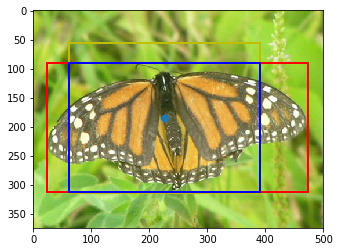

1
Pred class:  trolleybus, trolley coach, trackless trolley
Grund Truph: trolleybus, trolley coach, trackless trolley
IOU: [0.51455674]


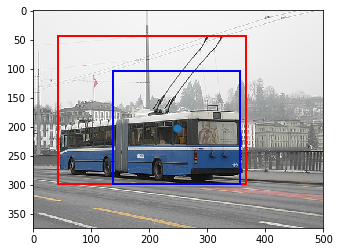

2
Pred class:  ambulance
Grund Truph: trolleybus, trolley coach, trackless trolley
IOU: [0.40055724]


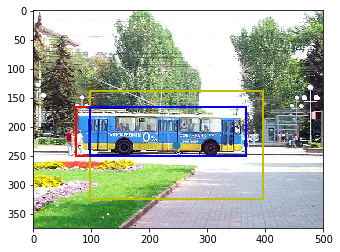

3
Pred class:  boxer
Grund Truph: boxer
IOU: [0.57749915]


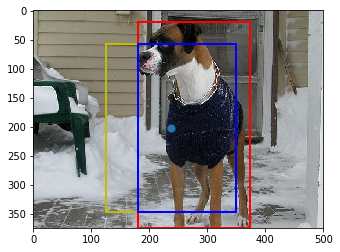

4
Pred class:  ambulance
Grund Truph: ambulance
IOU: [0.78411161]


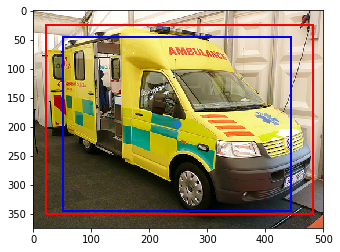

5
Pred class:  sea snake
Grund Truph: sea snake
IOU: [0.34484323]


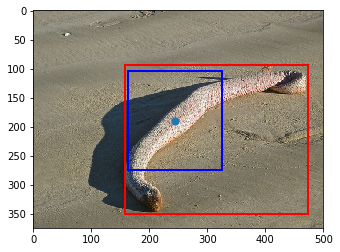

6
Pred class:  trolleybus, trolley coach, trackless trolley
Grund Truph: trolleybus, trolley coach, trackless trolley
IOU: [0.65270376]


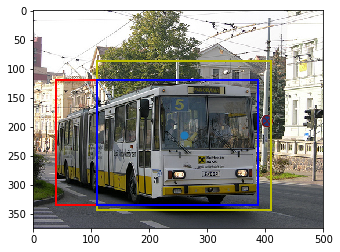

7
Pred class:  boxer
Grund Truph: boxer
IOU: [0.54840047]


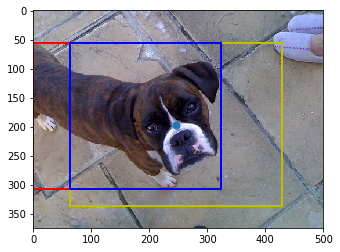

8
Pred class:  ambulance
Grund Truph: ambulance
IOU: [0.60428529]


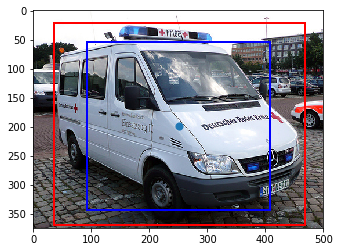

9
Pred class:  trolleybus, trolley coach, trackless trolley
Grund Truph: trolleybus, trolley coach, trackless trolley
IOU: [0.64972524]


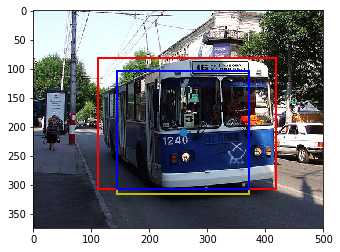

In [48]:
#for i in zero_iou_indexes[0]:
for i in range(10):
    f, ax = plt.subplots(1,1)
    prediction_index = i # + 30
    print(i)
    predicted_class_name = synset_dict[index_to_class[np.argmax(predictions_batch[0][prediction_index])]]
    ground_truth_class_id = data_to_predict[2][prediction_index].split('/')[0]
    filename = data_to_predict[2][prediction_index].split('/')[1]
    ground_truth_class_name = synset_dict[ground_truth_class_id]
    print('Pred class: ', predicted_class_name)
    print('Grund Truph:',ground_truth_class_name)
    bounding_box = annotations_dict_val[ground_truth_class_id][filename.split('.')[0]]['bounding_boxes'][0]
    im_w = images_batch[prediction_index].shape[1]
    im_h = images_batch[prediction_index].shape[0]
    centerX = predictions_batch[1][prediction_index][0]
    centerY = predictions_batch[1][prediction_index][1]
    width = predictions_batch[1][prediction_index][2]
    height = predictions_batch[1][prediction_index][3]
    
    predicted_bounding_box = [((centerX-width/2)*im_w), ((centerY-height/2)*im_h), ((centerX+width/2)*im_w), ((centerY+height/2)*im_h)]
    ax.imshow(images_batch[prediction_index])
    ax.scatter(centerX*im_w, centerY*im_h, s= 50)
    rect = patches.Rectangle(predicted_bounding_box[:2],
                                predicted_bounding_box[2]-predicted_bounding_box[0],
                                predicted_bounding_box[3]-predicted_bounding_box[1],
                                linewidth=2, edgecolor='y',facecolor='none')
    ax.add_patch(rect)
    rect_gt = patches.Rectangle(bounding_box[:2],
                                bounding_box[2]-bounding_box[0],
                                bounding_box[3]-bounding_box[1],
                                linewidth=2, edgecolor='r',facecolor='none')
    ax.add_patch(rect_gt)
    IOU, intersection_bb = getIUO(np.array([predicted_bounding_box]), np.array([bounding_box]))
    intersection_bb = intersection_bb[0]
    rect_int = patches.Rectangle(intersection_bb[:2],
                                intersection_bb[2]-intersection_bb[0],
                                intersection_bb[3]-intersection_bb[1],
                                linewidth=2, edgecolor='b',facecolor='none')
    ax.add_patch(rect_int)
    
    print('IOU:',IOU)
    plt.show()